In [180]:
import pandas as pd 
import gensim
from gensim.sklearn_api import d2vmodel
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from discourse_learning import D2VTx
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

Previous Work:

* Bag of Words.
* TF-IDF.
* Paragraph Vectors.
* Previous Paragraph's Label

In [320]:
class Features(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=8, max_df=.5):
        self.min_df = min_df
        self.max_df = max_df
    
    def fit(self, data_df, y=None):
        text = data_df['paragraph_text']
        self.cv = (
            CountVectorizer(stop_words='english', min_df=self.min_df, max_df=self.max_df)
                   .fit(text)
        )
        self.tfidf = (
            Pipeline([('vect', CountVectorizer(stop_words="english", min_df=self.min_df, max_df=self.max_df)),
                      ('tfidf', TfidfTransformer())])
                   .fit(text)
        )
        self.d2v = (
            D2VTx(dm=0, min_alpha=0.01, min_count=5, steps=50)
                   .fit(text.tolist())
        )
        self.label_mapping = {'LEAD': 0, 'CIRC': 1, 'MAIN': 2, 'VERB': 3,
                              'CONS': 4, 'PREV': 5, 'EVAL': 6, 'HIST': 7,
                              'EXPE': 8, 'SECD': 9, 'EXPL': 10, 'NONE': 11}
        return self
        
    def transform(self, data_df):
        text = data_df['paragraph_text']
        
        cv_vecs = self.cv.transform(text).todense()
        tfidf_vecs = self.tfidf.transform(text).todense()
        d2v_vecs = self.d2v.transform(text.tolist())

        prev_labels = data_df['prev label'].map(self.label_mapping).to_frame().values
        
        return np.hstack((cv_vecs, tfidf_vecs, d2v_vecs, prev_labels))

# Replicate Previous Work

In [155]:
pipe = Pipeline([
    ('features', Features(min_df=1, max_df=1.0)),
    ('svm', SVC(C=10, kernel="linear", class_weight='balanced'))
])

In [166]:
finlayson_df = pd.read_csv('../data/finlayson_data.csv', index_col=0).rename(columns={'text':'paragraph_text'})
finlayson_df['prev label'] = (
    finlayson_df['label']
     .pipe(lambda s: pd.concat([s.iloc[-1:], s.iloc[:-1]]))
     .reset_index(drop=True)
)

for value in finlayson_df.groupby('doc_key').groups.values():
    finlayson_df.at[value[0], 'prev label'] = 'NONE'

In [167]:
finlayson_df.head()

,doc_key,end,start,label,paragraph_text,prev label
0,9801.35,433,194,LEAD,The Senate yesterday confirmed three federal j...,NONE
1,9801.35,616,433,CIRC,But the dispute over the Senate's pace in deal...,LEAD
2,9801.35,887,616,MAIN,"By a vote of 67 to 30, the Senate confirmed An...",CIRC
3,9801.35,1116,887,VERB,Senate Judiciary Committee Chairman Orrin G. H...,MAIN
4,9801.35,1365,1116,MAIN,"By voice vote, the Senate also confirmed Richa...",VERB


In [187]:
kfolds = 5
kf = KFold(n_splits=kfolds)
f1s_finlayson = []

for train_index, test_index in tqdm(kf.split(finlayson_df), total=kfolds):
    df_train, df_test = finlayson_df.loc[train_index], finlayson_df.loc[test_index]
    pipe.fit(df_train, df_train['label'])
    y_pred = pipe.predict(df_test)
    f1s_finlayson.append({
        'f1_macro': f1_score(df_test['label'], y_pred, average='macro'),
        'f1_micro': f1_score(df_test['label'], y_pred, average='micro')
    })

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


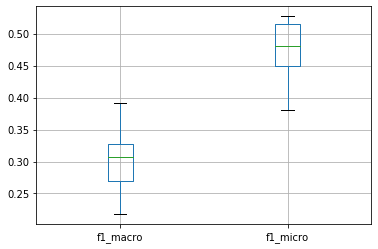

In [188]:
pd.DataFrame(f1s_finlayson).boxplot()

# Add in New Work

In [191]:
data_df = pd.read_csv('../data/combined_data_df.csv')

In [198]:
data_df['prev label'] = (data_df['label']
 .pipe(lambda s: pd.concat([s.iloc[-1:], s.iloc[:-1]]))
 .reset_index(drop=True)
)

data_df['label'] = data_df['label'].fillna('VERB')
for value in data_df.groupby('doc_key').groups.values():
    data_df.at[value[0], 'prev label'] = 'NONE'

In [193]:
data_df.head()

,doc_key,paragraph_text,start,end,label,corpus,prev label
0,9801.35,The Senate yesterday confirmed three federal j...,194,433,LEAD,finlayson,NONE
1,9801.35,But the dispute over the Senate's pace in deal...,433,616,CIRC,finlayson,LEAD
2,9801.35,"By a vote of 67 to 30, the Senate confirmed An...",616,887,MAIN,finlayson,CIRC
3,9801.35,Senate Judiciary Committee Chairman Orrin G. H...,887,1116,VERB,finlayson,MAIN
4,9801.35,"By voice vote, the Senate also confirmed Richa...",1116,1365,MAIN,finlayson,VERB


In [323]:
pipe = Pipeline([
    ('features', Features(min_df=1, max_df=1.0)), 
    ('svm', SVC(C=10, kernel='linear', class_weight='balanced'))
])

In [324]:
kfolds = 5
kf = KFold(n_splits=kfolds)
f1s = []

for train_index, test_index in tqdm(kf.split(data_df), total=kfolds):
    df_train, df_test = data_df.loc[train_index], data_df.loc[test_index]
    pipe.fit(df_train, df_train['label'])
    y_pred = pipe.predict(df_test)
    f1s.append({
        'f1_macro': f1_score(df_test['label'], y_pred, average='macro'),
        'f1_micro': f1_score(df_test['label'], y_pred, average='micro')
    })

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


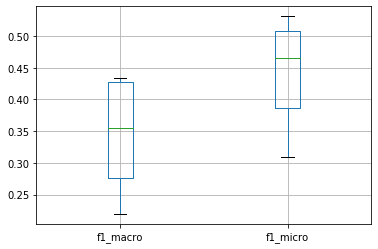

In [190]:
pd.DataFrame(f1s).boxplot()

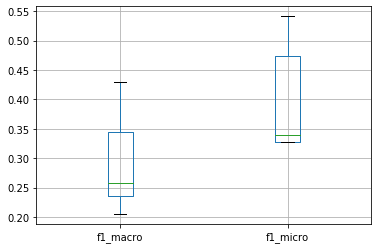

In [325]:
pd.DataFrame(f1s).boxplot()